# Predict Baseball Strike Zones with Machine Learning

Support Vector Machines are powerful machine learning models that can make complex decision boundaries. An SVM’s decision boundary can twist and curve to accommodate the training data.

In this project, we will use an SVM trained using a baseball dataset to find the decision boundary of the strike zone.  
<img src="Images/strike_zone.svg" width="400" style="display: block; margin: auto;" />
The strike zone can be thought of as a decision boundary that determines whether or not a pitch is a strike or a ball. There is a strict definition of the strike zone — in practice, however, it will vary depending on the umpire or the player at bat.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


def make_meshgrid(ax, h=.02):
    # x_min, x_max = x.min() - 1, x.max() + 1
    # y_min, y_max = y.min() - 1, y.max() + 1
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def draw_boundary(ax, clf):
    xx, yy = make_meshgrid(ax)
    return plot_contours(ax, clf, xx, yy,cmap=plt.cm.coolwarm, alpha=0.5)


aaron_judge = pd.read_csv('aaron_judge.csv')
jose_altuve = pd.read_csv('jose_altuve.csv')
david_ortiz = pd.read_csv('david_ortiz.csv')

## 1.

- We’ve imported several DataFrames related to some of baseball’s biggest stars. 
- We have data on Aaron Judge and Jose Altuve. 
- Judge is one of the tallest players in the league and Altuve is one of the shortest. 
- Their strike zones should be pretty different!

<br>

- Each row in these DataFrames corresponds to a single pitch that the batter saw in the 2017 season. 
- To begin, let’s take a look at all of the features of a pitch. 
- Print `aaron_judge.columns`.

<br>

- In this project, we’ll ask you to print out a lot of information. 
- To avoid clutter, feel free to delete the print statements once you understand the data.

<br>

- We used the [pybaseball](https://github.com/jldbc/pybaseball) Python package to get the data for this project. 
- If you’re interested in getting more data, the documentation for pybaseball can help you get data that you’re interested onto your own computer.

In [5]:
aaron_judge.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'pos2_person_id', 'umpire',
       'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pos1_person_id',
       'pos2_person_id.1', 'pos3_person_id', 'pos4_person_id',
       'pos5_person_id', 'pos6_person_id', 'pos7_person_id', 'pos8_person_id',

## 2.

- Some of these features have obscure names. 
- Let’s learn what the feature `description` means.
- Print `aaron_judge.description.unique()` to see the different values the `description` feature could have.

In [9]:
aaron_judge.description.unique()

array(['swinging_strike', 'called_strike', 'ball', 'hit_into_play_score',
       'foul', 'blocked_ball', 'hit_into_play', 'hit_into_play_no_out',
       'swinging_strike_blocked', 'foul_tip', 'hit_by_pitch'],
      dtype=object)

## 3.

- We’re interested in looking at whether a pitch was a ball or a strike. 
- That information is stored in the `type` feature. 
- Look at the unique values stored in the `type` feature to get a sense of how balls and strikes are recorded.

In [10]:
aaron_judge.type.unique()

array(['S', 'B', 'X'], dtype=object)

## 4.

- Great! We know every row’s `type` feature is either an `'S'` for a strike, a `'B'` for a ball, or an `'X'` for neither (for example, an `'X'` could be a hit or an out).
- We’ll want to use this feature as the label of our data points. 
- However, instead of using strings, it will be easier if we change every `'S'` to a `1` and every `'B'` to a `0`.
- You can change the values of a DataFrame column using the `map()` functions. 
- For example, in the code below, every `'A'` in `example_column` is changed to a `1`, and every `'B'` is changed to a `2`.
```python
df['example_column'] = df['example_column'].map({'A':1, 'B':2})
```

In [11]:
aaron_judge.type = aaron_judge.type.map({'S': 1, 'B': 0})

## 5.

- Let’s make sure that worked. 
- Print the `type` column from the `aaron_judge` DataFrame.

In [12]:
aaron_judge.type

0       1.0
1       1.0
2       1.0
3       0.0
4       1.0
       ... 
2984    1.0
2985    NaN
2986    0.0
2987    0.0
2988    NaN
Name: type, Length: 2989, dtype: float64

## 6.

- There were some `NaN`s in there. 
- We’ll take care of those in a second. 
- For now, let’s look at the other features we’re interested in.

<br>

- We want to predict whether a pitch is a ball or a strike based on its location over the plate. 
- You can find the ball’s location in the columns `plate_x` and `plate_z`.

<br>

- Print `aaron_judge['plate_x']` to see what that column looks like.

<br>

- `plate_x` measures how far left or right the pitch is from the center of home plate. 
- If `plate_x = 0`, that means the pitch was directly in the middle of the home plate.

In [14]:
aaron_judge.plate_x

0       1.0150
1       0.4546
2       0.0957
3       1.5161
4       0.0764
         ...  
2984   -0.3738
2985   -0.2953
2986    1.4094
2987    1.6717
2988   -0.1571
Name: plate_x, Length: 2989, dtype: float64

## 7.

- We now have the three columns we want to work with: `'plate_x'`, `'plate_z'`, and `'type'`.

<br>

- Let’s remove every row that has a `NaN` in any of those columns.

<br>

- You can do this by calling the `dropna` function.
- This function can take a parameter named `subset` which should be a list of the columns you’re interested in.

<br>

- For example, the following code drops all of the NaN values from the columns `'A'`, `'B'`, and `'C'`.
```python
data_frame = data_frame.dropna(subset = ['A', 'B', 'C'])
```

In [15]:
aaron_judge = aaron_judge.dropna(subset=['plate_x', 'plate_z', 'type'])

## 8.

- We now have points to plot using Matplotlib. 
- Call `plt.scatter()` using five parameters:
    - The parameter `x` should be the `plate_x` column.
    - The parameter `y` should be the `plate_z` column.
    - To color the points correctly, the parameter `c` should be the `type` column.
    - To make the strikes red and the balls blue, set the cmap parameter to `plt.cm.coolwarm`.
    - To make the points slightly transparent, set the `alpha` parameter to `0.25`.
- Call `plt.show()` to see your graph.

<br>

- `plate_z` measures how high off the ground the pitch was. 
- If `plate_z = 0`, that means the pitch was at ground level when it got to the home plate.

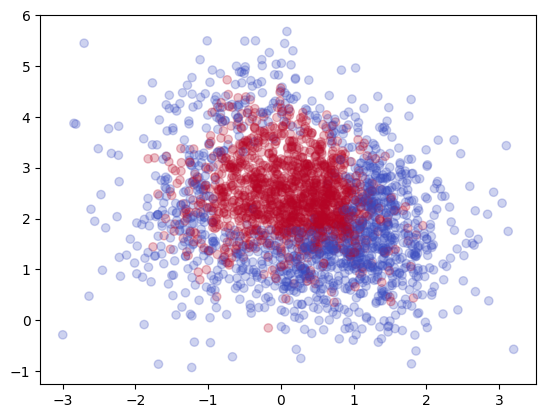

In [18]:
plt.scatter(aaron_judge.plate_x, aaron_judge.plate_z, c=aaron_judge.type, cmap=plt.cm.coolwarm, alpha=0.25)
plt.show()

## 9.

- Now that we’ve seen the location of every pitch, let’s create an SVM to create a decision boundary. 
- This decision boundary will be the real strike zone for that player. 
- For this section, make sure to write all of your code below the call to the `scatter` function but above the `show` function.

<br>

- To begin, we want to validate our model, so we need to split the data into a training set and a validation set.

<br>

- Call the `train_test_split` function using `aaron_judge` as a parameter.

<br>

- Set the parameter `random_state` equal to `1` to ensure your data is split in the same way as our solution code.

<br>

- This function returns two objects. 
- Store the return values in variables named `training_set` and `validation_set`.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(aaron_judge[['plate_x', 'plate_z']], aaron_judge.type, test_size=0.3, random_state=1)

## 10.

- Next, create an `SVC` named `classifier` with `kernel = 'rbf'`. 
- For right now, don’t worry about setting the `C` or `gamma` parameters.

In [20]:
classifier = SVC()

## 11.

- Call `classifier`‘s `.fit()` method. This method should take two parameters:
    - The training data. This is the `plate_x` column and the `plate_z` column in `training_set`.
    - The labels. This is the `type` column in `training_set`.

In [27]:
classifier.fit(X_train, y_train)

SVC()

## 12.

- To visualize the SVM, call the `draw_boundary` function. 
- This is a function that we wrote ourselves - you won’t find it in scikit-learn.
- This function takes two parameters:
    - The axes of your graph. For us, this is the `ax` variable that we defined at the top of your code.
    - The trained SVM. For us, this is `classifier`. Make sure you’ve called `.fit()` before trying to visualize the decision boundary.
- Run your code to see the predicted strike zone!

<br>

- Note that the decision boundary will be drawn based on the size of the current axes.
- So if you call `draw_boundary` before calling `scatter` function, you will only see the boundary as a small square.

<br>

- To get around this, you could manually set the size of the axes by using something like `ax.set_ylim(-2, 2)` before calling `draw_boundary`.

c:\Users\larsk\.virtualenvs\Codecademy-XphA9WxU\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


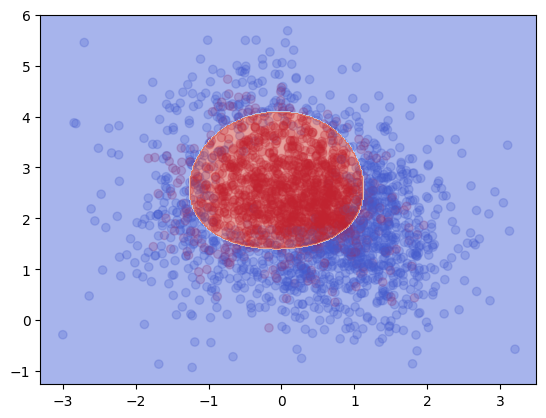

In [29]:
fig, ax = plt.subplots()
plt.scatter(aaron_judge.plate_x, aaron_judge.plate_z, c=aaron_judge.type, cmap=plt.cm.coolwarm, alpha=0.25)
draw_boundary(ax, classifier)
plt.show()

## 13.

- Nice work! We’re now able to see the strike zone. 
- But we don’t know how accurate our classifier is yet. 
- Let’s find its accuracy by calling the `.score()` method and printing the results.

<br>

- `.score()` takes two parameters — the points in the validation set and the labels associated with those points.

<br>

- These two parameters should be very similar to the parameters used in `.fit()`.

In [30]:
classifier.score(X_test, y_test)

0.8276729559748428

## 14.

- Let’s change some of the SVM’s parameters to see if we can get better accuracy.

<br>

- Set the parameters of the SVM to be `gamma = 100` and `C = 100`.

<br>

- This will overfit the data, but it will be a good place to start. 
- Run the code to see the overfitted decision boundary. 
- What’s the new accuracy?

0.789937106918239


c:\Users\larsk\.virtualenvs\Codecademy-XphA9WxU\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


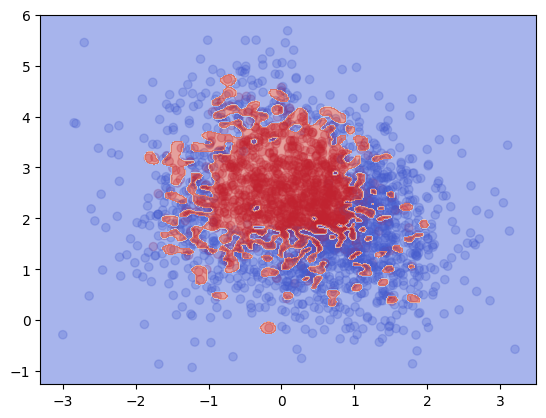

In [33]:
classifier = SVC(gamma=100, C=100)
classifier.fit(X_train, y_train)
print(classifier.score(X_test, y_test))


fig, ax = plt.subplots()
plt.scatter(aaron_judge.plate_x, aaron_judge.plate_z, c=aaron_judge.type, cmap=plt.cm.coolwarm, alpha=0.25)
draw_boundary(ax, classifier)
plt.show()

## 15.

- Try to find a configuration of `gamma` and `C` that greatly improves the accuracy. 
- You may want to use nested for loops.

<br>

- Loop through different values of `gamma` and `C` and print the accuracy using those parameters. 
- Our best SVM had an accuracy of 83.41%. 
- Can you beat ours?

In [42]:
from itertools import product

gammas = [0.001, 0.01, 0.1, 1, 10, 100]
Cs = [0.1, 1, 10, 100, 1000]
params = list(product(gammas, Cs))

scores = {}
for gamma, C in params:
    classifier = SVC(gamma=gamma, C=C)
    classifier.fit(X_train, y_train)
    scores[(gamma, C)] = classifier.score(X_test, y_test)

best_params = max(scores, key=scores.get)
best_params, scores[best_params]

((10, 1), 0.8377358490566038)

## 16.

- Finally, let’s see how different players’ strike zones change. 
- Aaron Judge is the tallest player in the MLB. 
- Jose Altuve is the shortest player. 
- Instead of using the `aaron_judge` variable, use `jose_altuve`.

<br>

- To make this easier, you might want to consider putting all of your code inside a function and using the dataset as a parameter.

<br>

- We’ve also imported `david_ortiz`.

<br>

- Note that the range of the axes will change for these players. 
- To really compare the strike zones, you may want to force the axes to be the same.

<br>

- Try putting `ax.set_ylim(-2, 6)` and `ax.set_xlim(-3, 3)` right before calling `plt.show()`

0.8308550185873605


c:\Users\larsk\.virtualenvs\Codecademy-XphA9WxU\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


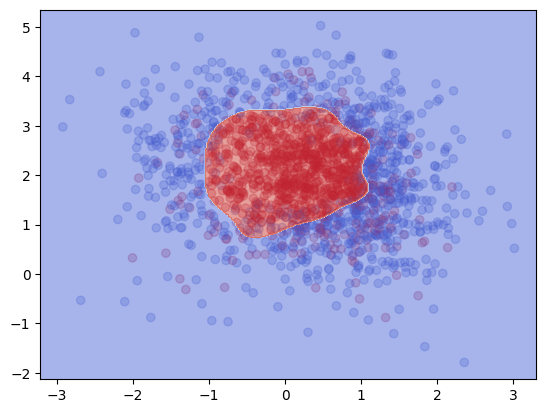

In [56]:
jose_altuve.type = jose_altuve.type.map({'S': 1, 'B': 0})
jose_altuve = jose_altuve.dropna(subset=['plate_x', 'plate_z', 'type'])

X_train, X_test, y_train, y_test = train_test_split(jose_altuve[['plate_x', 'plate_z']], jose_altuve.type, test_size=0.3, random_state=1)

fig, ax = plt.subplots()
plt.scatter(jose_altuve.plate_x, jose_altuve.plate_z, c=jose_altuve.type, cmap=plt.cm.coolwarm, alpha=0.25)
classifier = SVC(gamma=5, C=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_test, y_test))
draw_boundary(ax, classifier)
plt.show()

0.8344262295081967


c:\Users\larsk\.virtualenvs\Codecademy-XphA9WxU\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


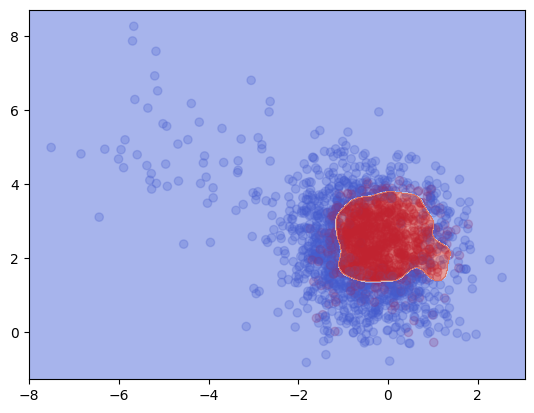

In [57]:
david_ortiz.type = david_ortiz.type.map({'S': 1, 'B': 0})
david_ortiz = david_ortiz.dropna(subset=['plate_x', 'plate_z', 'type'])

X_train, X_test, y_train, y_test = train_test_split(david_ortiz[['plate_x', 'plate_z']], david_ortiz.type, test_size=0.3, random_state=1)

fig, ax = plt.subplots()
plt.scatter(david_ortiz.plate_x, david_ortiz.plate_z, c=david_ortiz.type, cmap=plt.cm.coolwarm, alpha=0.25)
classifier = SVC(gamma=5, C=1)
classifier.fit(X_train, y_train)
print(classifier.score(X_test, y_test))
draw_boundary(ax, classifier)
plt.show()